In [1]:
# import libraries
import os
import pathlib
import glob
import random
import numpy as np
import tensorflow as tf
from keras import backend as K
import numpy as np
import cv2
import os

import PIL.Image as Image

import matplotlib.pylab as plt
import pandas as pd
import json

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D #to extract features
from keras.layers import MaxPooling2D #to reduce dimension and supress noise and also to make edges distinct
from keras.layers import Dense #classic fully connected layers to make classification
from keras.layers import Flatten #to convert multidimensional tensors to single dimension
from keras.layers.core import Dropout #to prevent overfitting
from keras_tuner import RandomSearch
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical # Function to convert labels to one-hot encoding
import tensorflow_addons as tfa

In [2]:
#set seed value
seed_value = 505

# Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

#Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
#  Set `numpy` pseudo-random generator at a fixed value

np.random.seed(seed_value)
#  Set `tensorflow` pseudo-random generator at a fixed value

tf.random.set_seed(seed_value)

In [3]:
# load dataset of sketches
data_dir = './data/png/'
data_dir = pathlib.Path(data_dir)

In [4]:
#start timer
from datetime import datetime
start = datetime.now() 
start_format = start.strftime("%m-%d-%Y-%H-%M-%S")

In [5]:
# set sketch_names equal to name of each folder in dataset
print("Images in dataset:",len(list(data_dir.glob('*/*.png'))))

Images in dataset: 20000


In [6]:
#define sketch names
sketch_names = os.listdir(data_dir)
#print(sketch_names[:5])
#sketch_names.remove('.DS_Store')
classes = sketch_names
num_classes = len(classes)
print("Number of classes:",num_classes)

Number of classes: 250


In [7]:
# Read images from disk(storage) into numpy array using opencv
sketch_images_dict = {f'{s}':list(data_dir.glob(f'{s}/*')) for s in sketch_names}

In [8]:
# Assign integer labels to categories
sketch_labels_dict = {x:i for i,x in enumerate(sketch_names)}

In [9]:
# create the value for X (features) and Y (labels)
X, y = [], []
from tqdm import tqdm
for sketch_name, images in tqdm(sketch_images_dict.items()):
    for image in images:
        img = cv2.imread(str(image),0)
        resized_img = cv2.resize(img,(128,128)) /255
        X.append(resized_img)
        y.append(sketch_labels_dict[sketch_name])

100%|██████████| 250/250 [01:18<00:00,  3.18it/s]


In [10]:
# make X and y numpy array
X = np.array(X)
y = np.array(y)

In [11]:
#split the data set into development set and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1)

print("X_train:",X_train.shape,"X-test:",X_test.shape)
print("y_train:",y_train.shape,"y_test:",y_test.shape)

X_train: (16000, 128, 128) X-test: (4000, 128, 128)
y_train: (16000,) y_test: (4000,)


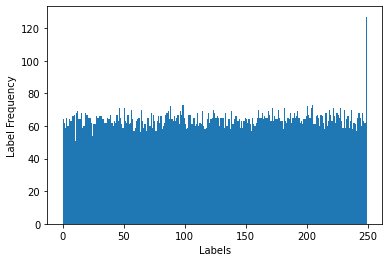

In [12]:
#examine how many samples per class in training set - is it balanced?
plt.figure()
plt.hist(y_train, bins = range(len(classes)))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.savefig("Label-Frequency")

In [13]:
#dataset recap
print("Development Dataset")
print("     Images: ",X_train.shape)
print("     Labels shape:",y_train.shape)
print("     Number of classes:",np.unique(y_train).size)
#print("     Classes:",np.unique(Y_train))
print("Test Dataset")
print("     Images: ",X_test.shape)
print("     Labels shape: ",y_test.shape)

Development Dataset
     Images:  (16000, 128, 128)
     Labels shape: (16000,)
     Number of classes: 250
Test Dataset
     Images:  (4000, 128, 128)
     Labels shape:  (4000,)


Testing Dataset Sample Images


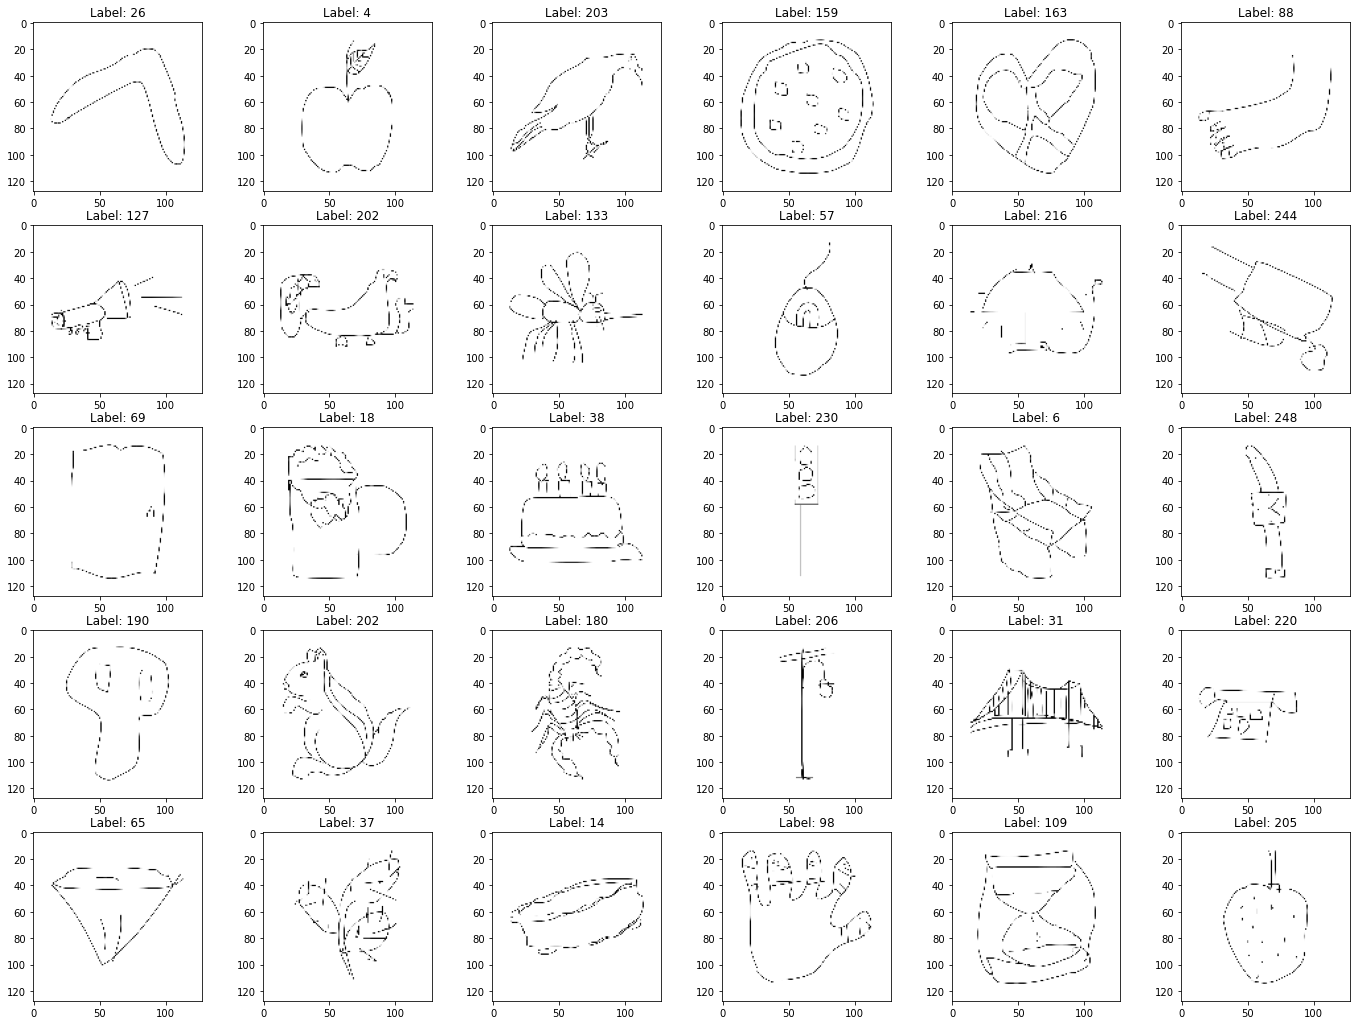

In [14]:
#display some samples from the training dataset
print("Testing Dataset Sample Images")
sample_indexes = np.random.choice(np.arange(X_train.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_train[jj], cmap = "gray")
    plt.title("Label: %d" %y_train[jj])
plt.show()

In [15]:
#normalized image when read in

In [16]:
#encode labels using one-hot-encoding 
y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_test_oh = keras.utils.to_categorical(y_test, num_classes)

In [17]:
#define model
model = keras.Sequential()
model.add(Conv2D(16, (3, 3),padding='same',input_shape=X_train.shape[1:]+(1,), activation='relu'))
model.add(Conv2D(16, (3, 3),padding='same',input_shape=X_train.shape[1:]+(1,), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(MaxPooling2D(pool_size =(2,2)))

model.add(Dropout(0.1,seed=seed_value))
model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dense(num_classes, activation='softmax')) 

# compile model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['top_k_categorical_accuracy',
                                                                          'categorical_accuracy', 'accuracy'])
#print model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

In [18]:
#train the model
tf.config.experimental_run_functions_eagerly(True)

csv_logger = tf.keras.callbacks.CSVLogger(f'metrics-{start_format}.csv',separator=",",append=True)

history = model.fit(x = X_train, y = y_train_oh, validation_split=0.1, batch_size = 64,  epochs=5, verbose=0, 
          callbacks=[TqdmCallback(verbose=2),
                     csv_logger])

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


0epoch [00:00, ?epoch/s]

C:\Users\rhump\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


  0%|          | 0.00/225 [00:00<?, ?batch/s]

  0%|          | 0.00/225 [00:00<?, ?batch/s]

  0%|          | 0.00/225 [00:00<?, ?batch/s]

  0%|          | 0.00/225 [00:00<?, ?batch/s]

  0%|          | 0.00/225 [00:00<?, ?batch/s]

In [19]:
#save model and report each epoch training accuracy and valudation accuracy
df = pd.read_csv(f'metrics-{start_format}.csv')
print(df.to_markdown())

model.save(f"model-{start_format}")
model_architecture = model.to_json()

#reconstructed_model = keras.models.load_model(f"model-{start_format}")
model.save_weights(f"model-weights-{start_format}")
with open(f"model-arch-{start_format}", "w") as f:
    json.dump(model_architecture, fp=f)

print(history.history.keys())

|    |   epoch |   accuracy |   categorical_accuracy |     loss |   top_k_categorical_accuracy |   val_accuracy |   val_categorical_accuracy |   val_loss |   val_top_k_categorical_accuracy |
|---:|--------:|-----------:|-----------------------:|---------:|-----------------------------:|---------------:|---------------------------:|-----------:|---------------------------------:|
|  0 |       0 |  0.0820139 |              0.0820139 | 4.78383  |                     0.199931 |       0.23125  |                   0.23125  |    3.72828 |                         0.446875 |
|  1 |       1 |  0.319653  |              0.319653  | 3.10022  |                     0.570417 |       0.3175   |                   0.3175   |    3.18161 |                         0.55625  |
|  2 |       2 |  0.555694  |              0.555694  | 1.88431  |                     0.793958 |       0.348125 |                   0.348125 |    3.02275 |                         0.6075   |
|  3 |       3 |  0.791111  |              0.

INFO:tensorflow:Assets written to: model-12-08-2022-12-43-33\assets


INFO:tensorflow:Assets written to: model-12-08-2022-12-43-33\assets


dict_keys(['loss', 'top_k_categorical_accuracy', 'categorical_accuracy', 'accuracy', 'val_loss', 'val_top_k_categorical_accuracy', 'val_categorical_accuracy', 'val_accuracy'])


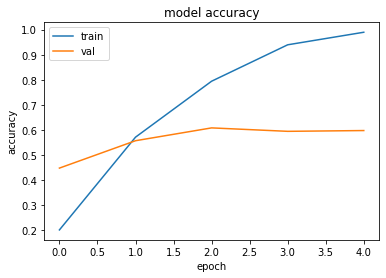

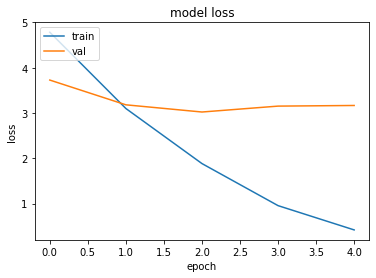

In [20]:
#plot accuracy (training and val) and loss (training and val)
plt.figure()
# summarize history for accuracy
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig(f"model-accuracy-{start_format}")
plt.show()

# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig(f"model-loss-{start_format}")
plt.show()

#Grab losses and stick into a dataframe
loss_df = pd.DataFrame(model.history.history)
#Plot out of the losses
#loss_df.plot()


In [21]:
#!pip install -U tensorflow-addons

In [22]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [23]:
# test the model and report accuracy of model on test dataset
score = model.evaluate(X_test, y_test_oh, batch_size=64,verbose=0,callbacks=[tqdm_callback])

print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))
print("Categorical cross-entropy:", score[0])
print("Accuracy:", score[1])

C:\Users\rhump\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


0/63           ETA: ?s - Evaluating

Test accuarcy: 59.05%
Categorical cross-entropy: 3.222045660018921
Accuracy: 0.590499997138977


125/125 [==============================] - 17s 134ms/step


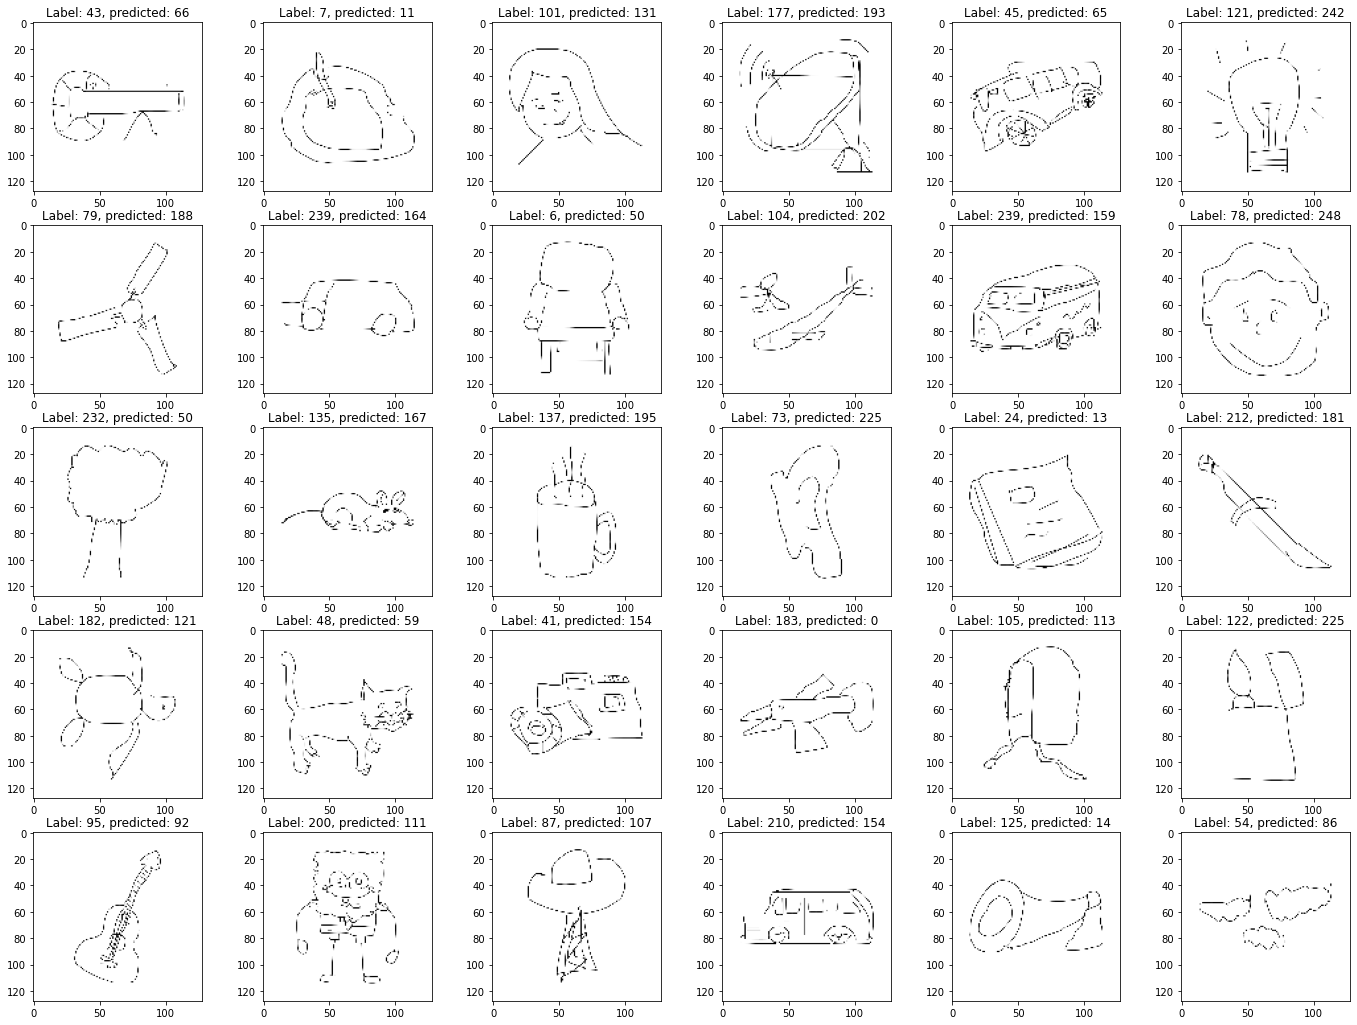

In [25]:
#displaying some samples with incorrect predictions
Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != y_test)[0]
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = True)
plt.figure(figsize = (24,18))
#for (ii,jj) in tqdm(enumerate(sample_indexes)):
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap="gray")
    plt.title("Label: %d, predicted: %d" %(y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))                      
plt.show()


In [26]:
#end timer and print runtime
now = datetime.now() 
duration = now - start                         # For build-in functions
duration_in_s = duration.total_seconds()  
minutes = divmod(duration_in_s, 60)[0]
print(f"\n\n ============>>>>>>  Training took {minutes} minutes")



 ============>>>>>>  Training took 25.0 minutes
